**In this project, I will process labelled news headlines, explore the text data, perform topic modelling, and then build predictive models to classify news headlines into different domains: Business, SciTech, Sports, World.**

In [397]:
'''data'''
import pandas as pd
import numpy as np
import spacy
import re
import os
import json
import itertools as it
import pickle

%run headlines_helper_functions.ipynb

'''Visualization'''
import matplotlib.pyplot as plt
import seaborn as sns

''' Features'''
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

'''Estimators'''
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier

'''Modelling'''
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score 
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc, confusion_matrix

## Import data

In [195]:
# Take a look at what the first headline looks like
with open("news_article_data.json") as file:
    first_record = file.readline()

print(first_record)  # two fields are of interest: "content" and "annotation".

{"content": "Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.","annotation":{"notes":"","label":["Business"]},"extras":null,"metadata":{"first_done_at":1521027375000,"last_updated_at":1521027375000,"sec_taken":0,"last_updated_by":"nlYZXxNBQefF2u9VX52CdONFp0C3","status":"done","evaluation":"NONE"}}



In [197]:
# Read in each headline and convert it to a Python dict, 
# get the text of each headline, and write it into a new text file that  
# contains  one headline per line in the file.

scratch_directory = os.path.join('scratch')

# create a scratch directory if one doesn't already exist
try:
    os.mkdir(scratch_directory)
except FileExistsError:
    pass

# name of the text file that contains all headline text
headline_txt_filepath = os.path.join(scratch_directory, 'headline_text_all.txt') 

In [198]:
headline_count = 0 #  init headline counter
labels = [] # a list for the headline labels

# create and open a new file in write mode
with open(headline_txt_filepath, 'w') as headline_txt_file:
    
    # open "news_article_data.json" in read mode (the original data file)
    with open ("news_article_data.json", 'r') as headline_json_file:
        
        # convert each json record into dict and write the headline text into the new file
        for line in headline_json_file:
            headline = json.loads(line)
            headline_txt_file.write(headline['content'] + '\n')
            headline_count +=1
            
            #Get label
            labels.append(headline['annotation']['label'][0])  
            

In [199]:
len(labels), headline_count

(7600, 7600)

************************************************************************************************************

## Using spaCy to process text

In [200]:
nlp = spacy.load('en_core_web_sm')

**Grab a sample headline to "play" with and try out the functionalities of spaCy.**

In [201]:
headline_num = 789

with open("news_article_data.json") as file:
    # convert the json record to a Python dict. "data" is a list of dicts
    data=[json.loads(line) for line in file]
    
sample_headline = data[headline_num]['content']
print(sample_headline)

Bea Arthur sparked a security scare at Logan Airport in Boston this week when she tried to board a Cape Air flight with a pocketknife in her handbag.    The "Golden Girls" star, now 81, was flagged by a Transportation Security Administration agent, who discovered the knife - a strict no-no following 9/11.    "She started yelling that it wasn't hers and said 'The terrorists put it there,' " a fellow passenger said. "She kept yelling about the 'terrorists, the terrorists, the terrorists.' "    After the blade was confiscated, Arthur took a keyring from her bag and told the agent it belonged to the "terrorists," before throwing it at them.  - via philly.com


In [202]:
nlp.pipe_names # nlp pipeline contains tagger, parser and ner models

['tagger', 'parser', 'ner']

In [203]:
parsed_headline = nlp(sample_headline) # apply spaCy nlp models to the sample headline (ex: tagger, parser, ner )

In [204]:
print(parsed_headline)

Bea Arthur sparked a security scare at Logan Airport in Boston this week when she tried to board a Cape Air flight with a pocketknife in her handbag.    The "Golden Girls" star, now 81, was flagged by a Transportation Security Administration agent, who discovered the knife - a strict no-no following 9/11.    "She started yelling that it wasn't hers and said 'The terrorists put it there,' " a fellow passenger said. "She kept yelling about the 'terrorists, the terrorists, the terrorists.' "    After the blade was confiscated, Arthur took a keyring from her bag and told the agent it belonged to the "terrorists," before throwing it at them.  - via philly.com


**The text looks the same so far, but spaCy already performed all the sentence detection, tokenization, normalization etc...**

**Sentence Detection**

In [205]:
parsed_headline.sents # sentencize the sample headline, I get a generator

In [206]:
for i, text in enumerate(parsed_headline.sents):
    print("Sentence number:{}".format(i))
    print(text)
    print('')

Sentence number:0
Bea Arthur sparked a security scare at Logan Airport in Boston this week when she tried to board a Cape Air flight with a pocketknife in her handbag.    

Sentence number:1
The "Golden Girls" star, now 81, was flagged by a Transportation Security Administration agent, who discovered the knife - a strict no-no following 9/11.    

Sentence number:2
"She started yelling that it wasn't hers and said 'The terrorists put it there,' " a fellow passenger said.

Sentence number:3
"She kept yelling about the 'terrorists, the terrorists, the terrorists.' "    

Sentence number:4
After the blade was confiscated, Arthur took a keyring from her bag and told the agent it belonged to the "terrorists," before throwing it at them.  

Sentence number:5
- via philly.com



**The headline is "sub-divided" into its sentences.  In other words, the headline is "sentencize".**

**Tokenization, lemmatization, and token shape analysis**

In [207]:
token_text = [token.text for token in parsed_headline] 
token_lemma = [token.lemma_ for token in parsed_headline] 
token_shape = [token.shape_ for token in parsed_headline]

In [208]:
temp= pd.DataFrame(zip(token_text, token_lemma, token_shape),
            columns= ['token text', 'token lemma', 'token shape'])

temp.sample(5)

,token text,token lemma,token shape
87,.,.,.
123,it,-PRON-,xx
68,it,-PRON-,xx
36,",",",",","
21,flight,flight,xxxx


### spaCY also performs part of speech tagging (detects the verb, noun, proper noun etc... in a sentence)
- Noun (N)- Daniel, London, table, dog, teacher, pen, city, happiness, hope
- Verb (V)- go, speak, run, eat, play, live, walk, have, like, are, is
- Adjective(ADJ)- big, happy, green, young, fun, crazy, three
- Adverb(ADV)- slowly, quietly, very, always, never, too, well, tomorrow
- Preposition (P)- at, on, in, from, with, near, between, about, under
- Conjunction (CON)- and, or, but, because, so, yet, unless, since, if
- Pronoun(PRO)- I, you, we, they, he, she, it, me, us, them, him, her, this
- Interjection (INT)- Ouch! Wow! Great! Help! Oh! Hey! Hi!

In [209]:
token_pos = [token.pos_ for token in parsed_headline]
temp = pd.DataFrame(
    zip(token_text, token_pos),
    columns=['token', 'part_of_speech']
    )

temp.sample(10)

,token,part_of_speech
99,",",PUNCT
57,-,PUNCT
118,bag,NOUN
121,the,DET
20,Air,PROPN
64,She,PRON
120,told,VERB
37,now,ADV
137,,SPACE
135,them,PRON


### Name Entity Recognition (NER)
- A name entity is a "real world object" that is assigned a name.  For example:
    - A person
    - A country
    - A product
    - A book title
        
- If my text data is a chapter of a fiction, and my task is to find out the character that appeared the most in that chapter, then I need NER.
- First, I need to identify the names in a sentence.
- Then I need to get a list of all the unique names that appear in all the sentences in the chapter.
- Finally, I count the number of times that each name appear.

In [210]:
parsed_headline

Bea Arthur sparked a security scare at Logan Airport in Boston this week when she tried to board a Cape Air flight with a pocketknife in her handbag.    The "Golden Girls" star, now 81, was flagged by a Transportation Security Administration agent, who discovered the knife - a strict no-no following 9/11.    "She started yelling that it wasn't hers and said 'The terrorists put it there,' " a fellow passenger said. "She kept yelling about the 'terrorists, the terrorists, the terrorists.' "    After the blade was confiscated, Arthur took a keyring from her bag and told the agent it belonged to the "terrorists," before throwing it at them.  - via philly.com

In [211]:
parsed_headline.ents # get the named entities

(Bea Arthur,
 Logan Airport,
 Boston,
 this week,
 Cape Air,
 The "Golden Girls" star,
 81,
 Transportation Security Administration,
 9/11,
 Arthur)

In [212]:
print(type(parsed_headline.ents)) # tuples that contains the word phrases (can be 1 or more words) and its named entity

<class 'tuple'>


In [213]:
for i, entity in enumerate(parsed_headline.ents):
    print("Entity {}: {} - {}".format(i+1, entity, entity.label_))

Entity 1: Bea Arthur - PERSON
Entity 2: Logan Airport - FAC
Entity 3: Boston - GPE
Entity 4: this week - DATE
Entity 5: Cape Air - PRODUCT
Entity 6: The "Golden Girls" star - FAC
Entity 7: 81 - DATE
Entity 8: Transportation Security Administration - ORG
Entity 9: 9/11 - CARDINAL
Entity 10: Arthur - PERSON


### Token-level attributes
- Whether or not a token is a:
    - stopword?
    - punctuation?
    - whitespace?
    - a number?
    - is part of spaCy's default vocabulary?

In [214]:
token_attributes = [(
        token.text,  # text
        token.prob, # log prob (frequency of word)
        token.is_stop, # stop word?
        token.is_punct, # a puncuation?
        token.is_space, # a whitespace?
        token.like_num, # a number?
        token.is_oov # not a spaCy vocab?
        ) for token in parsed_headline
    ]

In [215]:
temp = pd.DataFrame(token_attributes,
       columns=['text', 'log_probability',
        'stop?', 'punctuation?',
        'whitespace?', 'number?',
        'out of vocab.?']
    )

In [216]:
temp.loc[:, 'stop?':'out of vocab.?'] = (
    temp.loc[:, 'stop?':'out of vocab.?']
    .applymap(lambda x: 'Yes' if x else '')
    )
                                               
temp.tail(10)

,text,log_probability,stop?,punctuation?,whitespace?,number?,out of vocab.?
131,before,-20.0,Yes,,,,Yes
132,throwing,-20.0,,,,,Yes
133,it,-20.0,Yes,,,,Yes
134,at,-20.0,Yes,,,,Yes
135,them,-20.0,Yes,,,,Yes
136,.,-20.0,,Yes,,,Yes
137,,-20.0,,,Yes,,Yes
138,-,-20.0,,Yes,,,Yes
139,via,-20.0,Yes,,,,Yes
140,philly.com,-20.0,,,,,Yes


**NOTE:** 

- The interpretation of oov is, "tokens that don't have a meaningful probability value are words that are not in the vocab."

- oov is not that useful in the _sm models, and in general might not work well in data packs if there wasn't a big frequency count used to build the vocab.

************************************************************************************************************

## Processing Text
- Use spaCy to remove punctuation and lemmatize the text.
- Train and apply first-order phrase model to join word pairs.
- Train and apply second-order phrase model to join longer phrases.
- Remove stopwords.
- Create a bag-of-words representation.

In [217]:
from gensim.models.phrases import Phrases, Phraser
from gensim.models.word2vec import LineSentence

In [218]:
nlp = spacy.load('en_core_web_sm')

In [219]:
# text file that contains cleaned and lemmatized text
lemm_hl_filepath = os.path.join(scratch_directory, 'lemm_headline_txt_all.txt') 
# contains cleaned, lemmatized, and sentencized text 
lemm_hl_sent_filepath = os.path.join(scratch_directory, 'lemm_headline_sentence_all.txt') 

In [220]:
%%time
execute = False

if execute:
    
    with open(lemm_hl_filepath, 'w') as lemm_hl_file:   # open lemm_headline_txt_all.txt in write mode
         with open(lemm_hl_sent_filepath, 'w') as lemm_sentence_file: # open lemm_headline_sentence_all.txt in write mode
                
                # stream in the headlines from "headline_txt_all.txt" 500 at a time.
                # nlp.pipe applies nlp to each headline
                pipe = nlp.pipe( 
                    # read line for file that contains all headline text (one per line)
                    get_line_headline(headline_txt_filepath), 
                    batch_size = 500, 
                    n_threads=8)
        
                for headline in pipe:                    
                    # lemmatize each headline (convert from a list of tokens to a string)
                    lemm_headline = ' '.join([lemm(token) for token in headline if (not punct_space(token) and 
                                                                            get_alphanumeric(token))])
            
                    # Save the lemmatized text in "lemm_headline_txt_all.txt"
                    lemm_hl_file.write(lemm_headline + '\n')
            
            
                    # Sentencize each headline, and then lemmatize each sentence
                    for sentence in headline.sents: # sentencize each headline
                        # lemm each sentence
                        lemm_sentence = ' '.join([lemm(token) for token in sentence if (not punct_space(token) and
                                                                               get_alphanumeric(token))])
                        
                        #Save each of the lemmatized sentence as a new line in "lemm_headline_sentence_all.txt"
                        lemm_sentence_file.write(lemm_sentence + '\n')

Wall time: 0 ns


- In "lemm_headline_sentence_all.txt", I have one sentence of each headline per line.
- I use gensim LineSentence class to get an iterator of sentences. The LineSentence class allows me to easily work with other gensim components by streaming the docs (sentences) from disk (and not hold entire dataset/corpora in RAM at once).  
- Thus, using LineSentence from gensim, I can to up-scale my modelling pipeline to very large corpora.

In [224]:
sentences_unigrams = LineSentence(lemm_hl_sent_filepath) # a LineStence object that holds all sentences in my dataset

In [225]:
type(sentences_unigrams)

gensim.models.word2vec.LineSentence

**Let's Take a look at a few sample sentences in the transformed corpora.**

In [226]:
# look at sentences with index 10 to 20   (it.islice(iterator, start, end, step))
for sent_unigram in it.islice(sentences_unigrams, 10, 15):  
    print(sent_unigram)

['emi', 'have', 'apparently', 'negotiate', 'end', 'well', 'so', 'that', 'child', 'in', 'school', 'will', 'now', 'be', 'indoctrinate', 'about', 'the', 'illegality', 'of', 'download', 'music']
['the', 'ignorance', 'and', 'audacity', 'of', 'this', 'get', 'to', 'a', 'little', 'so', 'write', 'an', 'open', 'letter', 'to', 'the', 'dfes', 'about']
['unfortunately', 'pedantic', 'as', 'suppose', 'have', 'to', 'be', 'when', 'write', 'to', 'goverment', 'representative']
['but', 'hope', 'find', 'useful', 'and', 'perhaps', 'feel', 'inspired', 'to', 'do', 'something', 'similar', 'if', 'or', 'when', 'the', 'same', 'thing', 'have', 'happen', 'in', 'area']
['jaschan', 'self', 'confess', 'author', 'of', 'the', 'netsky', 'and', 'sasser', 'virus', 'for', '70', 'percent', 'of', 'virus', 'infection', 'in', '2004', 'accord', 'to', 'a', 'six', 'roundup', 'publish', 'wednesday', 'by', 'antivirus', 'company', 'sophos']


In [227]:
for sent_unigram in it.islice(sentences_unigrams, 10, 15): 
    print(' '.join(sent_unigram)) # convert to string
    print('') # add space between sentences

emi have apparently negotiate end well so that child in school will now be indoctrinate about the illegality of download music

the ignorance and audacity of this get to a little so write an open letter to the dfes about

unfortunately pedantic as suppose have to be when write to goverment representative

but hope find useful and perhaps feel inspired to do something similar if or when the same thing have happen in area

jaschan self confess author of the netsky and sasser virus for 70 percent of virus infection in 2004 accord to a six roundup publish wednesday by antivirus company sophos



## Phrase Modelling
- Learn combinations of tokens that together represents meaningful multi-word concepts (ex: "United States", "happy hour")
- These phrase models are developed by examining all the words in The headlines and looking for words that co-occur (i.e., appear one after another) together much more frequently than you would expect them to by random chance. 

- Two important parameters for phrase models:
    - $count_{min}$ is a user-defined parameter to ensure that accepted phrases occur a minimum number of times.
    - $threshold$ is a user-defined parameter to control how strong of a relationship between two tokens the model requires before accepting them as a phrase.

- Once our phrase model has been trained on our corpus, we can apply it to new text. When our model encounters two tokens in new text that identifies as a phrase, it will merge the two into a single new token.
- We would get multi-word expressions that represent common concepts, but aren't specifically named entities (ex: happy hour, in addition to named entities such as New York) to become phrases in the model.

**Finding Bigrams (first order phrase model)**
- Train a phrase model using the headline corpora to identify/link words into 2-word phrases (or bigrams).  For example, words that often appear together in the corpora will be linked together into a single token (ex: happy hour==> happy_hour)  

In [228]:
bigram_model_filepath = os.path.join(scratch_directory, 'bigram_phrase_model') 

In [229]:
# Train the bigram model
execute = False
if execute:
    # train the phrase model using the processed sentences (LineSentence object)
    bigram_phrases_model = Phrases(sentences_unigrams)
    # Use the Phraser function to turn the phrase model into a "Phraser" object, which is optimized for speed and memory use
    bigram_phrases_model = Phraser(bigram_phrases_model)
    #Save the model for future use
    bigram_phrases_model.save(bigram_model_filepath)

In [230]:
# Load the trained model from disk
bigram_phrases_model = Phraser.load(bigram_model_filepath)

In [231]:
bigram_phrases_model

**Apply the trained Phrase model to our lemmatized sentences**

In [232]:
# new file that contains transformed sentences (with bigrams)
sentences_bigrams_filepath = os.path.join(scratch_directory, 'sentence_bigram_phrases_all.txt')

In [233]:
execute = False

if execute:
    # write the sentences (with bigrams) in "sentence_bigram_phrases_all.txt"
    with open(sentences_bigrams_filepath, 'w') as bigram_file:
        for sent in sentences_unigrams: # sent is a list of tokens
            sent_with_bigram = ' '.join(bigram_phrases_model[sent])  # apply the phrase model to each lemmatized sentences
            bigram_file.write(sent_with_bigram + '\n') # write each transformed sentences into a text file

**The first-order transformed data is now organized with one document (sentence) per line in "sentence_bigram_phrases_all.txt".  As before, I use the gensim LineSentence class to get an LineSentence object for the entire set of documents.**

In [234]:
# load headlines with bigrams
sentences_bigrams = LineSentence(sentences_bigrams_filepath)

In [235]:
type(sentences_bigrams)

gensim.models.word2vec.LineSentence

**Finding Trigrams (second order phrase model)**
- I apply the second-order phrase model on top of the transformed data in "sentence_bigrams_phrases_all.txt"), so that incomplete word combinations like "big bad_wolf" will become fully joined to "big_bad_wolf".

**Train trigram model**

In [236]:
# new filepath for transformed sentences (with trigrams)
trigram_model_filepath = os.path.join(scratch_directory, 'trigram_phrase_model')

In [237]:
execute = False
if execute:
    trigram_phrases_model = Phrases(sentences_bigrams)
    trigram_phrases_model = Phraser(trigram_phrases_model)
    
    # Save model
    trigram_phrases_model.save(trigram_model_filepath)

In [238]:
# Load the trained model from disk
trigram_phrases_model = Phraser.load(trigram_model_filepath)

**Apply trained trigram phrase model to our "first-order transformed sentences" (aka sentences with bigrams). Then we will write the "second-order transformed sentences" (aka sentences with trigrams) into a file.**

In [239]:
sentences_trigrams_filepath = os.path.join(scratch_directory, 'sentence_trigram_phrases_all.txt')

In [240]:
execute = False
if execute:
    with open(sentences_trigrams_filepath, 'w') as trigram_file:
        for sent_bigram in sentences_bigrams: # iterate the LineSentence object that contains the set of docs with bigrams
            sent_trigram = ' '.join(trigram_phrases_model[sent_bigram])
            
            # write the transformed sentence into 'sentence_trigram_phrases_all.txt'
            trigram_file.write(sent_trigram + '\n')

**The second-order transformed data is now organized with one document (sentence) per line in "sentence_trigram_phrases_all.txt". As before, I use gensim LineSentence class to get a LineSentence object for the entire set of documents.**

In [241]:
# load headlines with trigrams
sentences_trigrams = LineSentence(sentences_trigrams_filepath)

## Process headlines
- Now that I have the trained bigram and trigram phraser models (from each individual sentences in my set of headlines), I will now process the lemmatized headlines data (that is not broken down into individual sentences).
- I will first create the gensim LineSentence object for the lemmatized headlines corpus.
- Second, I will apply the first and second order transformation to the headlines.
- Third, I will remove stopwords. Stopwords are very common words, like a, the, and, and so on, that serve functional roles in natural language, but typically don't contribute to the overall meaning of text (adds only noise). Filtering stopwords is a common procedure that allows higher-level NLP modeling techniques to focus on the words that carry more semantic weight.
- Finally, I will write the transformed headlines (with trigrams, one for each line) into a file.

In [242]:
headlines_trigrams_filepath = os.path.join(scratch_directory, 'headlines_trigrams_all.txt')

In [243]:
execute = True
l_hl_trigrams = []

if execute:
    # create the LineSentence iterator for the lemmatized headlines
    lemm_headlines = LineSentence(lemm_hl_filepath)
    
    # write the transformed headlines into "headlines_trigrams_all.txt"
    with open(headlines_trigrams_filepath, 'w') as headlines_trigram_file:
        
        for hl_unigram in lemm_headlines: # get each headline from the lemm_headlines LineSentence object
            # apply the trained bigram and trigram phrase models to each headline
            hl_bigram = bigram_phrases_model[hl_unigram]
            hl_trigram = trigram_phrases_model[hl_bigram]
            
            # remove stopwords from each of the transformed headline
            hl_trigram = [t for t in hl_trigram if t not in nlp.Defaults.stop_words]
            l_hl_trigrams.append(hl_trigram) # a list of list of transformed tokens
            
            # convert the list of tokens into a single string for each transformed headline
            hl_trigram = ' '.join(hl_trigram)
            
            # write the transformed headline (with trigram) into "headlines_trigrams_all.txt"
            headlines_trigram_file.write(hl_trigram + '\n')            

**Compared the original headline and transformed headline**
- What I did?
    - Tokenized and lemmatized text.
    - Removed stopwords, punctuations, and non-alphanumeric characters.
    - Include bigrams and trigrams.

In [244]:
headline_num = 200

with open("news_article_data.json") as file:  
    data=[json.loads(line) for line in file]
    
sample_headline = data[headline_num]['content']
print('Original:' + '\n')
print(sample_headline)


print('\n')
print('Transformed:' + '\n')

with open(headlines_trigrams_filepath) as file:
    for transformed_sample in it.islice(file, headline_num, headline_num+1):
        print(transformed_sample)

Original:

Single mothers, poverty were big factors in school performance    HealthDayNews -- American teenagers who live with poor single mothers are more likely to get into trouble at school and have poor marks and are less likely to think they'll go to college, says a Rice University study.    Holly Heard, an assistant professor of sociology, analyzed data from thousands of teens who took part in the National Longitudinal Study of Adolescent Health...


Transformed:

single mother poverty big factor school performance healthdaynew american teenager live poor single mother likely trouble school poor mark likely think college rice university study holly heard assistant professor sociology analyze datum thousand_of teen take_part national longitudinal study adolescent health



## Explore the text data
- Find the most frequent words in all of the headlines
- Average word count by category
- Most frequent bigrams
- The distribution of word count of headlines by category

In [245]:
df = pd.DataFrame(list(zip(l_hl_trigrams, labels)), columns = ['headline', 'label'])

In [246]:
# remove \n 
df["headline"] = df["headline"].apply(lambda x: [token.replace('\n','') for token in x])  

In [247]:
# Get the top 10 most frequent words int he corpus
wf = word_freq(l_hl_trigrams, 20) # use a list of list of transformed tokens
wf.head(20)

,words,counts
0,company,610
1,new,593
2,ap,539
3,reuters,428
4,win,361
5,yesterday,347
6,report,338
7,year,279
8,group,276
9,game,265


**Average word count by category**

In [248]:
#Avg word count by category
df['word_count'] = df['headline'].apply(word_count)

In [249]:
df.head()

,headline,label,word_count
0,"[union, represent, worker, turner, newall, dis...",Business,12
1,"[toronto, canada, rocketeer, compete, million_...",SciTech,15
2,"[ap, company, found, chemistry, researcher, un...",SciTech,20
3,"[ap, barely, dawn, mike, fitzpatrick, start, s...",SciTech,27
4,"[ap, southern_california, smog, fighting, agen...",SciTech,18


In [250]:
avg_word_count = df.groupby('label').mean().reset_index()
print(avg_word_count)

      label  word_count
0  Business   16.598421
1   SciTech   16.630526
2    Sports   16.703684
3     World   17.061053


**Top 15 words by category** 

In [251]:
top_n = 15

In [252]:
text_bus = df.loc[df.label=='Business','headline'].tolist()
text_sci_t = df.loc[df.label=='SciTech','headline'].tolist()
text_sports = df.loc[df.label=='Sports','headline'].tolist()
text_world = df.loc[df.label=='World','headline'].tolist()

l_text = [text_bus, text_sci_t, text_sports, text_world]

In [253]:
wf =[word_freq(l,top_n) for l in l_text]

In [254]:
df_wf = pd.concat(wf, axis=1)
cols = ['business', 'count', 'sci tech', 'count', 'sports', 'count', 'world', 'count']
df_wf.columns = cols
df_wf

,business,count,sci tech,count,sports,count,world,count
0,company,313,new,293,win,251,ap,206
1,report,149,company,274,team,207,reuters,186
2,new,139,microsoft,213,game,206,afp,151
3,stock,127,software,147,ap,204,people,144
4,million,124,service,140,season,158,leader,136
5,new_york_reuters,117,use,137,play,119,government,130
6,rise,116,internet,124,lead,114,country,130
7,billion,115,technology,121,player,109,kill,113
8,sale,115,launch,118,yesterday,107,new,106
9,yesterday,113,ap,111,time,104,group,105


**Top 15 word phrases (bigrams or trigrams) by category** 

In [255]:
nf =[ngrams_freq(l,top_n) for l in l_text]

In [256]:
df_ngf = pd.concat(nf, axis=1)
cols = ['business', 'count', 'sci tech', 'count', 'sports', 'count', 'world', 'count']
df_ngf.columns = cols
df_ngf

,business,count,sci tech,count,sports,count,world,count
0,new_york_reuters,117,plan_to,63,sports_network,77,in_iraq,72
1,on_tuesday,105,accord_to,62,on_sunday,61,official_say,72
2,on_monday,104,version_of,52,victory_over,56,president_bush,70
3,on_thursday,85,on_tuesday,51,win_over,56,prime_minister,66
4,on_wednesday,83,on_monday,48,last_night,54,on_tuesday,65
5,oil_price,81,this_week,46,on_saturday,54,be_kill,63
6,on_friday,67,and_other,44,new_york,49,on_monday,62
7,quote_profile_research,64,on_wednesday,42,on_wednesday,41,on_thursday,61
8,plan_to,63,more_than,36,red_sox,38,on_friday,60
9,new_york,62,mobile_phone,36,united_states,37,united_nations,56


**Plot the distribution of word count by headline**

(0, 80)

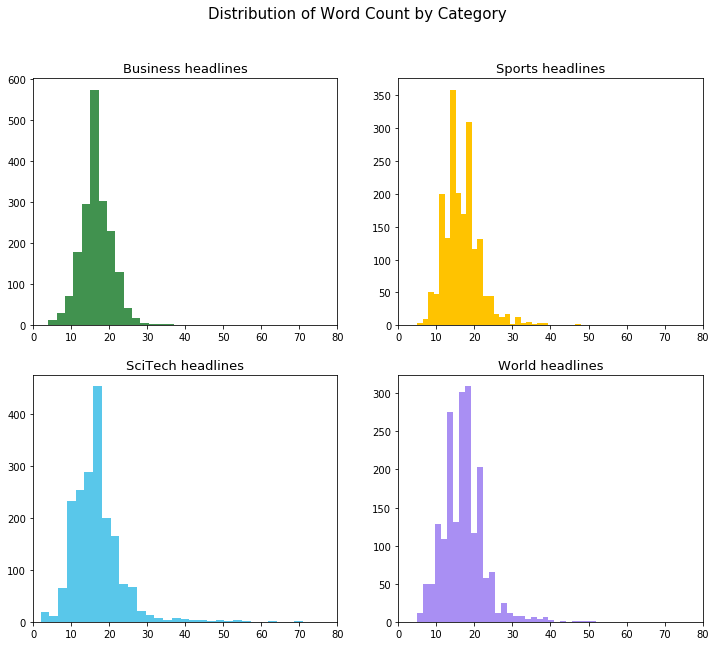

In [257]:
fig, ax = plt.subplots(2, 2, figsize = (12,10)) # 4 subplots, one for each class
fig.suptitle('Distribution of Word Count by Category', fontsize=15) # super title

bins = 30

ax[0,0].hist(df.loc[df.label == "Business", "word_count"], bins = bins, color = '#41924F')
ax[0,0].set_title('Business headlines', fontsize = 13)
ax[0,0].set_xlim(0, 80)

ax[1,0].hist(df.loc[df.label == "SciTech", "word_count"], bins = bins, color = '#59C7EA')
ax[1,0].set_title('SciTech headlines', fontsize = 13)
ax[1,0].set_xlim(0, 80)

ax[0,1].hist(df.loc[df.label == "Sports", "word_count"], bins = bins, color = '#FFC300')
ax[0,1].set_title('Sports headlines', fontsize = 13)
ax[0,1].set_xlim(0, 80)

ax[1,1].hist(df.loc[df.label == "World", "word_count"], bins = bins, color = '#a98ff3')
ax[1,1].set_title('World headlines', fontsize = 13)
ax[1,1].set_xlim(0, 80)

- Expected word count is About 15-18 words in each headline for each class
- A few really long headlines for SciTech
- Normally distributed, slightly right skewed

## Topic Modelling
- Topic modeling is a method for unsupervised classification of documents, similar to clustering on numeric data, which finds some natural groups of items (topics) even when we’re not sure what we’re looking for.
- It is similar to clustering for numerical data.
- Topic modeling provides methods for automatically organizing, understanding, searching, and summarizing large electronic archives.
    - Discovering the hidden themes in the collection.
    - Classifying the documents into the discovered themes.
    - Using the classification to organize/summarize/search the documents.
    - For example, let’s say a document belongs to the topics food, dogs and health. So if a user queries “dog food”, they might find the above-mentioned document relevant because it covers those topics(among other topics).  Therefore, by annotating the document, based on the topics predicted by the modeling method, we are able to optimize our search process.

## LDA basics:
https://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/
- One of the most popular topic modeling methods. 
-  Each document is made up of various words, and each topic also has various words belonging to it. 
-  The aim of LDA is to find topics a document belongs to, based on the words in it.
- Assumptions:
    - We know beforehand how many topics we want. ‘k’ is pre-decided.
    - Each document is just a collection of words or a “bag of words”.
   
- Two parts in LDA:
    - The words that belong to a document, that we already know.
    - The words that belong to a topic or the probability of words belonging into a topic, that we need to calculate.
- We use an algorithm to find the latter.

- LDA represents documents as a mixture of topics. Similarly, a topic is a mixture of words. If a word has high probability of being in a topic, all the documents having w will be more strongly associated with t as well. 
- Similarly, if w is not very probable to be in t, the documents which contain the w will be having very low probability of being in t, because rest of the words in d will belong to some other topic and hence d will have a higher probability for those topic. 
- So even if w gets added to t, it won’t be bringing many such documents to t.

In [260]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis.gensim
import warnings
import pickle

**The first step to creating an LDA model is to learn the full vocabulary of the corpus to be modeled. I use "gensim.corpora Dictionary" class for this.**

In [261]:
corpus_dict_filepath = os.path.join(scratch_directory, 'trigram_dict_all.dict')

In [262]:
# Create the LineSentence object
headline_trigrams = LineSentence(headlines_trigrams_filepath)

execute = False
if execute:
    # learn the dictionary by iterating over all of the headlines
    dictionary_trigrams = Dictionary(headline_trigrams)

    # Filter tokens that are very rare or too common in the dictionary (filter_extremes) and reassign integer ids (compactify)
    dictionary_trigrams.filter_extremes(no_below=20, no_above=0.4)
    dictionary_trigrams.compactify()

    # Save the corpus dictionary
    dictionary_trigrams.save(corpus_dict_filepath)

In [263]:
# load the finished dictionary from disk
dictionary_trigrams = Dictionary.load(corpus_dict_filepath)

- LDA assumes that documents are represented by the bag-of-words model. In the bag-of-words model, a document is represented by the counts of distinct terms that occur within it. Additional information, such as word order, is discarded.
- BOW vectors are sparsed (mostly 0s) and large.
- I generate a bag-of-words representation for each headline (implemented by the trigram_bow_generator function) Then I save the resulting bag-of-words representations of the headlines as a matrix (each row is a document, each column is a sparse vector for each token in the document).

In [264]:
# file for the BOW matrix (represents documents)
bow_corpus_filepath = os.path.join(scratch_directory, 'bow_trigrams_corpus_all.mm') 

In [265]:
# generator function to read headlines from a file and yield a bag-of-words representation
def bow_generator(filepath):
    for hl in LineSentence(filepath):
        yield dictionary_trigrams.doc2bow(hl) # for each document, get its bow representation using the corpora dictionary

In [266]:
execute = False
if execute:
    # Generate bag-of-words representations for all headlines and save them as a matrix
    MmCorpus.serialize(bow_corpus_filepath, bow_generator(headlines_trigrams_filepath))

In [267]:
# Load the finished bag-of-words corpus from disk
trigram_bow_corpus = MmCorpus(bow_corpus_filepath)

- With the bag-of-words corpus, we are start to learn our topic model from the headlines. We need to pass the bag-of-words matrix and Dictionary from our to the LdaMulticore function as inputs. 
- We also need to specify the number of topics the model should learn. 
- We specifiy K=4 topics (which coincide with the "true" number of topics that we have in our headline corpus).

In [271]:
set(labels) # I have 4 "true" classes

{'Business', 'SciTech', 'Sports', 'World'}

In [272]:
lda_model_filepath = os.path.join(scratch_directory, 'lda_model_all')

In [273]:
 with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # workers => sets the parallelism, and should be
        # set to your number of physical cores minus one
        lda = LdaMulticore(
            trigram_bow_corpus,
            num_topics=4,
            id2word=dictionary_trigrams,
            workers=1
            )
lda.save(lda_model_filepath)

In [274]:
# load the trained LDA model from disk
lda = LdaMulticore.load(lda_model_filepath)

- Our topic model is now trained and ready to be used. 
- Since each topic is represented as a mixture of tokens, you can manually inspect which tokens have been grouped together into which topics to try to understand the patterns the model has discovered in the data.

In [275]:
# use a user-supplied topic number and print out a formatted list of the top tokens
def explore_topic(topic_number, topn=15):
    print(f'{"term":20} {"frequency"}' + '\n') # column headers
    
    for term, frequency in lda.show_topic(topic_number, topn):
        print(f'{term:20} {round(frequency, 3):.3f}')

In [276]:
set(label)

NameError: name 'label' is not defined

In [ ]:
explore_topic(topic_number=0)   # Business

In [ ]:
explore_topic(topic_number=1)    # World or Business?

In [ ]:
explore_topic(topic_number=2) # SciTech?

In [ ]:
explore_topic(topic_number=3) # sports

**In case the news headlines are not labelled in this problem, then I can apply LDA to the corpus and examine the tokens that are grouped in each topic and figure out what the topic might be. Then I can labelled each of the documents/headlines with these topics.**

- Manually review the top terms for each topic is a helpful exercise to figure out what the topic might be. 
- But to get a deeper understanding of the topics and how they relate to each other, we need to visualize the data — preferably in an interactive format.  - We use the pyLDAvis libary for that.  It is a library that takes topic models from gensim and prepare visualizations with the data.

In [ ]:
LDAvis_data_filepath = os.path.join(scratch_directory, 'ldavis_prepared')

In [ ]:
'''
The pyLDAvis.gensim.prepare function takes the gensim lda model, the bow representation of the documents (a matrix), and 
the corpus dictionary generated from gensim as inputs
'''
execute = False
if execute:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda, trigram_bow_corpus, dictionary_trigrams)

    with open(LDAvis_data_filepath, 'wb') as f:  # write binary (file mode)
        pickle.dump(LDAvis_prepared, f)

In [ ]:
# load the prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

- Use the pyLDAvis display function to display the topic model visualization inline in the notebook

- The interactive visualization pyLDAvis produces is helpful for both:
    - (1) Better understanding and interpreting individual topics, and
    - (2) Better understanding the relationships between the topics.

- For (1), you can manually select each topic to view its top most freqeuent and/or "relevant" terms, using different values of the $\lambda$ parameter. This can help when you're trying to assign a human interpretable name or "meaning" to each topic.

- For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [ ]:
pyLDAvis.display(LDAvis_prepared)

## Text Description for LDA
- Besides "clustering" documents into topics, one of the main uses of LDA is to provide a compact and qunatitative description of text data.
- Once LDA model is trained, it can be used to represent documents as a mixture of topics (some with more weights/probability than others).
- This mixture can be interpreted as a probability distribution across the topics, so the LDA representation of a paragraph of text might look like 50% Topic A, 20% Topic B, 20% Topic C, and 10% Topic D.

**Here I use "existing" headlines from the dataset.  However, if I have "new" headlines that are unlabelled, then I can use LDA (trained from existing labelled headlines) to estimate the label for the new unlabelled headlines.**

In [278]:
headline_num = 1452 

with open("news_article_data.json") as file:
    # convert the json record to a Python dict. "data" is a list of dicts
    data=[json.loads(line) for line in file]
    

sample_headline = data[headline_num]['content']
print(sample_headline)

The global extinction crisis is worse than thought, because thousands of  quot;affiliated quot; species also at risk do not figure in calculations.


In [285]:
lda_description(sample_headline)

Sports                    0.657
Business                  0.290


## Word Embeddings representations with word2vec
- The goal of word vector embedding models is to learn dense, numerical vector representations for each term in a corpus vocabulary.
- The vectors it learns about each term should encode some information about the meaning or concept the term represents, and the relationship between it and other terms in the vocabulary. 
- Word vector models are also fully unsupervised — they learn all of these meanings and relationships solely by analyzing the text of the corpus, without any advance knowledge provided.
- Perhaps the best-known word vector model is word2vec, originally proposed in 2013. The general idea of word2vec is, for a given focus word, to use the context of the word — i.e., the other words immediately before and after it — to provide hints about what the focus word might mean. To do this, word2vec uses a sliding window technique, where it considers snippets of text only a few tokens long at a time.

- At the start of the learning process, the model initializes random vectors for all terms in the corpus vocabulary. 
- The model then slides the window across every snippet of text in the corpus, with each word taking turns as the focus word. 
- Each time the model considers a new snippet, it tries to learn some information about the focus word based on the surrouding context, and it "nudges" the words' vector representations accordingly. 
- One complete pass sliding the window across all of the corpus text is known as a training epoch. It's common to train a word2vec model for multiple passes/epochs over the corpus. 
- Over time, the model rearranges the terms' vector representations such that terms that frequently appear in similar contexts have vector representations that are close to each other in vector space.

- Word2vec has a number of user-defined hyperparameters, including:
    - The dimensionality of the vectors. I choose 300 for this example.
    - The width of the sliding window, in tokens. Five is a common default choice, but narrower and wider windows are possible.
    - The number of training epochs.

**If I want to train my own word2vec model with my corpus, gensim comes with a highly-optimized implementation word2vec algorithm with its Word2Vec class.**

In [286]:
from gensim.models import Word2Vec

# get LineSentence iterator of my headlines (with trigrams and stopwords removed)
sentences_trigrams = LineSentence(sentences_trigrams_filepath) 
word2vec_filepath = os.path.join(scratch_directory, 'word2vec_model_all')

In [287]:
execute = False

if execute:
    
    # initiate the model and perform the 20 epoch of training
    w2v = Word2Vec( 
        sentences_trigrams, # LineSentence object of the transformed headline corpus
        size=300, # size of the word vector
        window=5, # size of the window
        min_count=3, # Ignores all words with total frequency lower than this.
        sg=1, # Training algorithm: 1 for skip-gram; otherwise CBOW.
        workers=1, # Use these many worker threads to train the model
        iter=20 # number of epoch
        )
    
    # save model
    w2v.save(word2vec_filepath)

**The training is streamed, meaning sentences can be a generator, reading input data from disk on-the-fly, without loading the entire corpus into RAM. It also means you can continue training the model later:**

In [288]:
# load model
w2v = Word2Vec.load(word2vec_filepath)

print(f'The model was trained with {w2v.epochs} epochs.')

# train with new words if necessary
# w2v.train([['hello','world','I','am','here']], total_examples=1, epochs=1)

# The trained word vectors are stored in a KeyedVectors instance in w2v.wv:
# vector = w2v.wv['computer']  # numpy vector of a word


# Gensim instances of KeyedVectors (the common interface of sets of word-vectors) 
# contain a method init_sims(), which internally calculates unit-length 
# normalized vectors using a native vector operation for speed.

w2v.init_sims() # precompute the normalized vectors

The model was trained with 20 epochs.


The reason for separating the trained vectors into KeyedVectors is that if you don’t need the full model state any more (don’t need to continue training), the state can discarded, resulting in a much smaller and faster object that can be mmapped for lightning fast loading and sharing the vectors in RAM between processes:

In [289]:
# from gensim.models import KeyedVectors

# path = get_tmpfile("wordvectors.kv") # path the save model as a keyvector file
# word_vectors = KeyedVectors.load(word2vec_filepath, mmap='r')
# vector = word_vectors['computer']  # numpy vector of a word

In [290]:
print(f'{len(w2v.wv.vocab):,} terms in the w2v vocabulary, each with its 300x1 dense vector representations.')

561 terms in the w2v vocabulary, each with its 300x1 dense vector representations.


In [291]:
# Build a DataFrame that contains a set of word embeddings that I learnt
# I can get the index and count (frequency of word)
ordered_vocab=[(term, voc.index, voc.count) for term, voc in w2v.wv.vocab.items()]

In [292]:
ordered_vocab[:5]

[('union', 434, 61),
 ('worker', 294, 81),
 ('at', 15, 1070),
 ('say', 13, 1133),
 ('be', 6, 3754)]

In [293]:
# sort by the term counts, so the most common terms appear first
ordered_vocab = sorted(ordered_vocab, key=lambda term_tuple: -term_tuple[2])

In [294]:
ordered_vocab[:5]

[('the', 0, 12464),
 ('a', 1, 6424),
 ('of', 2, 5085),
 ('to', 3, 4820),
 ('in', 4, 4548)]

In [295]:
# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

In [296]:
ordered_terms[:5]

('the', 'a', 'of', 'to', 'in')

In [297]:
term_indices[:5]

(0, 1, 2, 3, 4)

In [298]:
term_counts[:5]

(12464, 6424, 5085, 4820, 4548)

In [299]:
# create a DataFrame with the w2v vectors as data, and the terms as row labels
word_vectors_df = pd.DataFrame(
    w2v.wv.vectors_norm[term_indices, :],
    index=ordered_terms
    )

word_vectors_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
injury,-0.028678,0.003672,-0.046433,0.042980,-0.050665,-0.097703,0.064402,-0.070111,-0.047728,-0.100487,...,0.014500,-0.022889,0.005913,-0.019160,0.071120,0.065715,-0.033689,-0.061767,-0.013519,0.056492
question,0.015104,0.026804,0.020081,0.060929,0.007962,-0.014428,0.025457,0.004132,0.097565,-0.015763,...,-0.062230,-0.069003,-0.033870,-0.006200,0.068917,0.057053,-0.040870,-0.122160,-0.024437,-0.005812
airline,0.044040,-0.012662,0.028198,0.082535,-0.037324,-0.018668,0.063906,0.016214,-0.075572,-0.100135,...,-0.085299,-0.071514,-0.059542,-0.056584,-0.014410,0.062958,-0.046979,-0.038288,0.031768,0.111603
receive,-0.047220,-0.005763,0.046993,0.097229,0.050526,-0.048636,-0.066621,-0.022332,-0.029707,-0.148279,...,-0.025118,-0.040520,-0.031505,-0.143225,-0.014615,0.158997,0.005598,0.012431,0.008274,0.027896
tokyo,-0.054072,-0.102392,0.026237,0.039517,0.032118,-0.006891,-0.020864,0.052435,-0.102598,-0.110021,...,-0.029326,-0.031980,-0.043148,0.001361,-0.081997,0.072917,-0.051460,0.011985,0.001258,0.040532


**The w2v model has "embedded" the terms into a 300-dimensional vector space.**

In [300]:
# This function prints the 10 most similar words to the target word
def get_related_terms(token, top_n=10):

    for word, similarity in w2v.wv.most_similar(positive=[token], topn=top_n):

        print(f'{word:20} {round(similarity, 3)}')

In [301]:
# words similar in context to "software"
get_related_terms("software")

microsoft            0.601
server               0.595
computer             0.594
device               0.59
pc                   0.578
version_of           0.575
digital              0.565
product              0.551
intel                0.551
wireless             0.543


In [302]:
get_related_terms("score")

yard                 0.792
victory_over         0.766
minute               0.703
throw                0.684
defeat               0.682
win_over             0.627
sports_network       0.613
beat                 0.602
point                0.59
night                0.58


In [303]:
get_related_terms("tokyo")

near                 0.583
new_york_reuters     0.548
send                 0.545
japanese             0.52
trade                0.513
rebel                0.507
unit                 0.506
target               0.504
force                0.493
global               0.491


### Experimenting with word embeddings
- Provide a set of words or phrases that you'd like to add or subtract.
- Look up the vectors that represent those terms in the word vector model.
- Add and subtract those vectors to produce a new, combined vector.
- Look up the most similar vector(s) to this new, combined vector via cosine similarity.
- Return the word(s) associated with the similar vector(s).

In [304]:
def word_algebra(add=[], subtract=[], topn=1):
    """
    combine the vectors associated with the words provided
    in add= and subtract=, look up the topn most similar
    terms to the combined vector, and print the result(s)
    """
    answers = w2v.wv.most_similar(positive=add, negative=subtract, topn=topn) # get the resultant word embedding
    
    for term, similarity in answers:
        print(term)

In [305]:
word_algebra(add=['trade', 'new_york'])

tokyo


In [306]:
word_algebra(add=['computer', 'wireless'], subtract=['system'])

network


## Word Vector Visualization with t-SNE
- t-Distributed Stochastic Neighbor Embedding, or t-SNE for short, is a dimensionality reduction technique to assist with visualizing high-dimensional datasets. It attempts to map high-dimensional data onto a low two- or three-dimensional representation such that the relative distances between points are preserved as closely as possible in both high-dimensional and low-dimensional space.

In [307]:
# scikit-learn has a TSNE class, we will use that implementation of t-sne
from sklearn.manifold import TSNE

**Our input for t-SNE will be the DataFrame of word vectors we created before. But beore that, we will:**
- Drop stopwords — it's probably not too interesting to visualize the, of, or, and so on


In [308]:
tsne_input = (word_vectors_df.drop(nlp.Defaults.stop_words, errors='ignore')) #drop stopwords from the word embeddings
tsne_input.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
company,-0.022861,-0.050449,0.001595,0.035906,0.096397,-0.034569,0.135193,0.068926,-0.020791,-0.061270,...,-0.013287,-0.100581,0.022391,-0.050550,0.023841,0.087962,0.017231,0.007809,0.009132,0.013007
new,0.039907,-0.026529,0.048099,-0.049626,0.114245,-0.084603,-0.062243,0.019767,0.012817,-0.024371,...,0.072619,-0.117317,-0.022663,-0.022308,-0.037683,0.077738,0.077305,-0.045504,-0.005399,-0.119434
ap,0.033210,0.013962,-0.063282,0.082089,-0.033795,-0.086432,-0.101568,-0.060251,0.016080,-0.090278,...,0.032503,0.004069,-0.017299,0.011773,-0.001047,0.078769,0.004370,-0.135862,0.022339,-0.077558
reuters,-0.035826,-0.120221,-0.046875,0.050515,-0.033914,0.000618,-0.061435,-0.067835,0.005880,-0.093429,...,0.015985,-0.075737,-0.038027,-0.056025,-0.032797,0.113574,-0.008005,-0.163231,0.056703,-0.078024
win,0.021388,0.031692,-0.012135,0.066727,0.079087,-0.052649,-0.011732,-0.106668,-0.040447,-0.039560,...,0.047772,-0.129981,0.052506,0.026554,-0.018875,0.082755,0.032691,-0.056480,-0.069349,0.018326


In [309]:
tsne_input.values # array of arrays

array([[-0.02286081, -0.0504493 ,  0.00159523, ...,  0.00780879,
         0.00913223,  0.01300692],
       [ 0.03990682, -0.02652893,  0.0480987 , ..., -0.04550416,
        -0.00539919, -0.11943393],
       [ 0.03321031,  0.01396197, -0.06328236, ..., -0.13586223,
         0.0223388 , -0.07755819],
       ...,
       [ 0.04403977, -0.01266175,  0.02819777, ..., -0.03828754,
         0.03176774,  0.11160297],
       [-0.04722004, -0.00576312,  0.04699276, ...,  0.01243058,
         0.00827442,  0.02789558],
       [-0.05407192, -0.10239225,  0.02623746, ...,  0.01198477,
         0.0012576 ,  0.04053189]], dtype=float32)

In [310]:
tsne_filepath = os.path.join(scratch_directory, 'tsne_model')
tsne_vectors_filepath = os.path.join(scratch_directory, 'tsne_vectors.npy')

In [311]:
execute = True
if execute:
    # init the tsne object
    tsne=TSNE() 
    tsne_vectors = tsne.fit_transform(tsne_input.values) # array of 300-D word embedding arrays as input
    
    with open(tsne_filepath, 'wb') as f:
        pickle.dump(tsne, f) # save the tsne model
        pd.np.save(tsne_vectors_filepath, tsne_vectors) # save the transformed tsne_vectors

In [312]:
# load the tsne_vectors
with open(tsne_filepath, 'rb') as f:
    tsne = pickle.load(f) # get the tsne model

tsne_vectors = pd.np.load(tsne_vectors_filepath) # get the tsne vectors    

# put tsne vectors into a DataFrame
tsne_vectors = pd.DataFrame(
    tsne_vectors,
    index=pd.Index(tsne_input.index), # row index are the tokens
    columns=['x_coord', 'y_coord']  # each token nly have 2 dimensions now 
    )

In [313]:
tsne_vectors.head()  # tsne vectors are 2-D represnetations of the 300D word-embedding vectors

,x_coord,y_coord
company,0.960939,10.573793
new,11.290567,15.837771
ap,4.219782,-18.188538
reuters,-9.832167,10.965966
win,21.045237,-9.763946


In [314]:
tsne_vectors['word'] = tsne_vectors.index 
tsne_vectors.head()

,x_coord,y_coord,word
company,0.960939,10.573793,company
new,11.290567,15.837771,new
ap,4.219782,-18.188538,ap
reuters,-9.832167,10.965966,reuters
win,21.045237,-9.763946,win


## Plotting Word Vectors with Bokeh

In [315]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

In [316]:
# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(
    title='t-SNE Word Embeddings',
    plot_width=800,
    plot_height=800,
    tools=(
        'pan, wheel_zoom, box_zoom,'
        'box_select, reset'
        ),
    active_scroll='wheel_zoom'
    )

# add a hover tool to display words on roll-over
tsne_plot.add_tools(
    HoverTool(tooltips = '@word')
    )

# draw the words as circles on the plot
tsne_plot.circle(
    'x_coord',
    'y_coord',
    source=plot_data,
    color='blue',
    line_alpha=0.2,
    fill_alpha=0.1,
    size=10,
    hover_line_color='black'
    )

# configure visual elements of the plotc
tsne_plot.title.text_font_size = value('16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

## Text Categorization with spaCy's textcat

- https://www.kaggle.com/poonaml/text-classification-using-spacy
- https://datascience.stackexchange.com/questions/55896/how-to-train-a-spacy-model-for-text-classification

## Process data

**I need to wrangle the data to a form that is preferred by spAcy textcat**

In [317]:
with open("news_article_data.json") as file:
    first_record = file.readline()

print(first_record)

{"content": "Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.","annotation":{"notes":"","label":["Business"]},"extras":null,"metadata":{"first_done_at":1521027375000,"last_updated_at":1521027375000,"sec_taken":0,"last_updated_by":"nlYZXxNBQefF2u9VX52CdONFp0C3","status":"done","evaluation":"NONE"}}



In [320]:
set(labels)

{'Business', 'SciTech', 'Sports', 'World'}

In [321]:
# a list of headlines that belong to one of the four classes
business_headlines = [] # a list of tuples of text and a dict of labels
scitech_headlines = []
sports_headlines = []
world_headlines = []

In [322]:
# lists that contain the text and the labels from all the headlines
all_content = []
all_type = []

In [323]:
with open('news_article_data.json') as file:
    for i, headline in enumerate(file):
        headline = json.loads(headline) # convert to dict
        
        # populate text and label from all headlines
        all_content.append(headline['content'])
        all_type.append(headline['annotation']['label'][0])
    
        # populate the list of (text, label) tuples in a format that is preferred by spaCy textcat
        if headline['annotation']['label'][0] =="Business":
            business_headlines.append((
            headline['content'], # text
            {'cats': {'business': 1.0, 'scitech': 0.0, 'sports': 0.0, 'world': 0.0}} # labels
            ))
            continue
            
        if headline['annotation']['label'][0] == "SciTech":
            scitech_headlines.append((
            headline['content'], # text
            {'cats': {'business': 0.0, 'scitech': 1.0, 'sports': 0.0, 'world': 0.0}} # labels
            ))
            continue
            
        if headline['annotation']['label'][0] == "Sports":
            sports_headlines.append((
            headline['content'], # text
            {'cats': {'business': 0.0, 'scitech': 0.0, 'sports': 1.0, 'world': 0.0}} # labels
            ))
            continue
            
        if headline['annotation']['label'][0] == "World":
            world_headlines.append((
            headline['content'], # text
            {'cats': {'business': 0.0, 'scitech': 0.0, 'sports': 0.0, 'world': 1.0}} # labels
            ))
            continue

**Take a look at a headline in spaCy's preferred format**

In [324]:
headline_text, headline_label = business_headlines[1]
print(headline_text)
print('')
print(headline_label)

Reuters - Apparel retailers are hoping their\back-to-school fashions will make the grade among\style-conscious teens and young adults this fall, but it could\be a tough sell, with students and parents keeping a tighter\hold on their wallets.

{'cats': {'business': 1.0, 'scitech': 0.0, 'sports': 0.0, 'world': 0.0}}


In [325]:
headline_text, headline_label = scitech_headlines[1]
print(headline_text)
print('')
print(headline_label)

AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.

{'cats': {'business': 0.0, 'scitech': 1.0, 'sports': 0.0, 'world': 0.0}}


In [326]:
headline_text, headline_label = sports_headlines[1]
print(headline_text)
print('')
print(headline_label)

FOXBOROUGH -- Looking at his ridiculously developed upper body, with huge biceps and hardly an ounce of fat, it's easy to see why Ty Law, arguably the best cornerback in football, chooses physical play over finesse. That's not to imply that he's lacking a finesse component, because he can shut down his side of the field much as Deion Sanders ...

{'cats': {'business': 0.0, 'scitech': 0.0, 'sports': 1.0, 'world': 0.0}}


In [327]:
headline_text, headline_label = world_headlines[1]
print(headline_text)
print('')
print(headline_label)

AP - The man who claims Gov. James E. McGreevey sexually harassed him was pushing for a cash settlement of up to  #36;50 million before the governor decided to announce that he was gay and had an extramarital affair, sources told The Associated Press.

{'cats': {'business': 0.0, 'scitech': 0.0, 'sports': 0.0, 'world': 1.0}}


In [328]:
len(business_headlines), len(scitech_headlines), len(sports_headlines), len(world_headlines)

(1900, 1900, 1900, 1900)

### In addition to using the original headline text as features, we also want to try using the "transformed" text as features (tokenized, lemmatized, stopwords and non-alphanumeric characters removed, bigrams and trigrams identified)

**Wrangle the transformed text in a format that is preferrable by textcat**

In [329]:
# get the processed text
transformed_content = []
with open(headlines_trigrams_filepath) as file:
    for headline in file:
        transformed_content.append(headline)

In [330]:
headline_df = pd.DataFrame(list(zip(all_content, transformed_content, all_type)), columns = ['content', 'transformed', 'type'])

In [331]:
headline_df.head()

,content,transformed,type
0,Unions representing workers at Turner Newall...,union represent worker turner newall disappoin...,Business
1,"SPACE.com - TORONTO, Canada -- A second\team o...",toronto canada rocketeer compete million_ansar...,SciTech
2,AP - A company founded by a chemistry research...,ap company found chemistry researcher universi...,SciTech
3,AP - It's barely dawn when Mike Fitzpatrick st...,ap barely dawn mike fitzpatrick start shift bl...,SciTech
4,AP - Southern California's smog-fighting agenc...,ap southern_california smog fighting agency em...,SciTech


In [332]:
headline_df["transformed"] = headline_df["transformed"].apply(lambda x: x.replace('\n',''))  # remove \n

In [333]:
# get DataFrames of transformed headline texts for each class
t_business_df = headline_df.loc[headline_df.type=="Business", ["transformed", "type"]]
t_scitech_df = headline_df.loc[headline_df.type=="SciTech",  ["transformed", "type"]]
t_sports_df = headline_df.loc[headline_df.type=="Sports",  ["transformed", "type"]]
t_world_df = headline_df.loc[headline_df.type=="World",  ["transformed", "type"]]

In [334]:
 # a list of tuples that contains the transformed text and its associated label in spaCy textcat's preferrable format
t_business_headlines = [] 
t_scitech_headlines = []
t_sports_headlines = []
t_world_headlines = []

for row in t_business_df.values.tolist():
    t_business_headlines.append((row[0], # text
                                 {'cats': {'business': 1.0, 'scitech': 0.0, 'sports': 0.0, 'world': 0.0}} )) # labels  
        
for row in t_scitech_df.values.tolist():
    t_scitech_headlines.append((row[0], # text
                                 {'cats': {'business': 0.0, 'scitech': 1.0, 'sports': 0.0, 'world': 0.0}} )) # labels  

        
for row in t_sports_df.values.tolist():
    t_sports_headlines.append((row[0], # text
                                 {'cats': {'business': 0.0, 'scitech': 0.0, 'sports': 1.0, 'world': 0.0}} )) # labels
    
        
for row in t_world_df.values.tolist():
    t_world_headlines.append((row[0], # text
                                 {'cats': {'business': 0.0, 'scitech': 0.0, 'sports': 0.0, 'world': 1.0}} )) # labels 

In [335]:
# take a look at a headline
text, cat = t_business_headlines[0]
print(text)
print('')
print(cat)

union represent worker turner newall disappoint talk_with stricken parent firm federal mogul

{'cats': {'business': 1.0, 'scitech': 0.0, 'sports': 0.0, 'world': 0.0}}


In [336]:
text, cat = t_scitech_headlines[0]
print(text)
print('')
print(cat)

toronto canada rocketeer compete million_ansari_x_prize contest fund suborbital space flight officially announce date manned rocket

{'cats': {'business': 0.0, 'scitech': 1.0, 'sports': 0.0, 'world': 0.0}}


In [337]:
text, cat = t_sports_headlines[0]
print(text)
print('')
print(cat)

michael_phelps win gold_medal 400 individual medley set world_record time 4 minute second

{'cats': {'business': 0.0, 'scitech': 0.0, 'sports': 1.0, 'world': 0.0}}


In [338]:
text, cat = t_world_headlines[0]
print(text)
print('')
print(cat)

canadian_press vancouver cp sister man_who die violent confrontation police demand city chief constable resign defend officer involve

{'cats': {'business': 0.0, 'scitech': 0.0, 'sports': 0.0, 'world': 1.0}}


### We'll split the data 70/30 into train and test sets, then randomly shuffle each set.

In [343]:
import random

In [348]:
train_data = business_headlines[:int(len(business_headlines) *0.7)] + scitech_headlines[:int(len(scitech_headlines) * 0.7)] + sports_headlines[:int(len(sports_headlines) *0.7)] + world_headlines[:int(len(world_headlines) * 0.7)]

test_data = business_headlines[int(len(business_headlines) * 0.7):] + scitech_headlines[int(len(scitech_headlines) * 0.7):] + sports_headlines[int(len(sports_headlines) * 0.7):] + world_headlines[int(len(world_headlines) * 0.7):] 

In [349]:
random.shuffle(train_data)
random.shuffle(test_data)

In [350]:
len(train_data), len(test_data)

(5320, 2280)

**Repeat the same thing for the transformed data**

In [351]:
t_train_data = t_business_headlines[:int(len(t_business_headlines) * 0.7)] + t_scitech_headlines[:int(len(t_scitech_headlines) *0.7)] + t_sports_headlines[:int(len(t_sports_headlines) *0.7)] + t_world_headlines[:int(len(t_world_headlines) *0.7)]
t_test_data = t_business_headlines[int(len(t_business_headlines) *0.7):] + t_scitech_headlines[int(len(t_scitech_headlines) *0.7):] + t_sports_headlines[int(len(t_sports_headlines)*0.7):] + t_world_headlines[int(len(t_world_headlines)*0.7):] 

In [352]:
random.shuffle(t_train_data)
random.shuffle(t_test_data)

In [353]:
len(t_train_data), len(t_test_data)

(5320, 2280)

**Next, we'll create a new textcat model and add it to our existing nlp spaCy pipeline.**

In [354]:
original_pipe_names = nlp.pipe_names
original_pipe_names

['tagger', 'parser', 'ner']

In [355]:
# create the textcat model, default model that it uses is CNN
textcat = nlp.create_pipe(
    'textcat',
    config={'exclusive_classes': True} # classes are mutually exclusive (binary classification)
    )

# add labels to the model
textcat.add_label('business')
textcat.add_label('scitech')
textcat.add_label('sports')
textcat.add_label('world')

1

In [356]:
# add textcat model to the pipe
nlp.add_pipe(textcat)
nlp.pipe_names

['tagger', 'parser', 'ner', 'textcat']

In [357]:
# This function helps us evaluate the performance of our text classification model
def evaluate(tokenizer, textcat, texts, cats):
    
    docs = (tokenizer(text) for text in texts)
    
    tp = 0.0  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 0.0  # True negatives
    
    for i, doc in enumerate(textcat.pipe(docs)):
        # get the labels for each headline in the test dataset (ex: {Business:1, SciTech:0, Sports:0, World:0})
        gold = cats[i]['cats'] 
        
        # label and score and the predicted z-score for each label
        for label, score in doc.cats.items(): 
            #print((label, score))
            
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.0
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.0
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    
    # Compute the estimated test precision, recall and f1-score (from the validation-set approach)
    precision = tp / (tp + fp)  # I use micro-averaging method here
    recall = tp / (tp + fn)
    
    if (precision + recall) == 0:
        f_score = 0.0
    else:
        f_score = 2 * (precision * recall) / (precision + recall)
    
    return {"textcat_p": precision, "textcat_r": recall, "textcat_f": f_score}

**We start the training loop for our textcat model, using train_data for training the model and test_data for evaluating its performance.**

In [358]:
from spacy.util import minibatch

In [359]:
with nlp.disable_pipes(*original_pipe_names): # disable ner, tagger, and parser, leaving only textcat enabled in nlp 
    
    optimizer = nlp.begin_training() # initialize weights in CNN model (the default model of textcat)
    
    print("Training the model...")
    print("{:^5}\t{:^5}\t{:^5}\t{:^5}".format("LOSS", "P", "R", "F"))
    
    for i in range(10):
        losses = {}

        # batch up the examples using spaCy's minibatch
        random.shuffle(train_data)

        batches = minibatch(train_data, size=8)

        for batch in batches:
            texts, cats = zip(*batch)  # train text and labels
            nlp.update(texts, cats, sgd=optimizer, drop=0.2, losses=losses) # update model with new train data

        with textcat.model.use_params(optimizer.averages):

            # evaluate model on the test data 
            test_texts, test_cats = zip(*test_data)
            scores = evaluate(nlp.tokenizer, textcat, test_texts, test_cats)

        print(
            "{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}".format(  # print a simple table of train loss, and test precision, recall and f-score of each epoch
                losses["textcat"],
                scores["textcat_p"],
                scores["textcat_r"],
                scores["textcat_f"],
                )
            )

Training the model...
LOSS 	  P  	  R  	  F  
6.682	0.812	0.317	0.456
3.815	0.830	0.752	0.789
2.260	0.831	0.795	0.813
1.513	0.846	0.813	0.829
1.036	0.835	0.807	0.820
0.715	0.828	0.806	0.817
0.597	0.832	0.818	0.825
0.526	0.834	0.821	0.827
0.408	0.832	0.818	0.825
0.332	0.830	0.818	0.824


**Train and assess model using transformed data**

In [360]:
with nlp.disable_pipes(*original_pipe_names):
    
    optimizer = nlp.begin_training()
    
    print("Training the model...")
    print("{:^5}\t{:^5}\t{:^5}\t{:^5}".format("LOSS", "P", "R", "F"))
    
    for i in range(10):
        losses = {}

        # batch up the examples using spaCy's minibatch
        random.shuffle(t_train_data)

        batches = minibatch(t_train_data, size=8)

        for batch in batches:
            texts, cats = zip(*batch)
            nlp.update(texts, cats, sgd=optimizer, drop=0.2, losses=losses)

        with textcat.model.use_params(optimizer.averages):

            # evaluate on the dev data split off in load_data()
            test_texts, test_cats = zip(*t_test_data)
            scores = evaluate(nlp.tokenizer, textcat, test_texts, test_cats)

        print(
            "{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}".format(  # print a simple table
                losses["textcat"],
                scores["textcat_p"],
                scores["textcat_r"],
                scores["textcat_f"],
                )
            )

Training the model...
LOSS 	  P  	  R  	  F  
2.598	0.799	0.759	0.778
1.210	0.796	0.773	0.784
0.782	0.797	0.783	0.790
0.573	0.792	0.778	0.785
0.357	0.794	0.783	0.788
0.346	0.793	0.780	0.787
0.266	0.787	0.778	0.783
0.218	0.789	0.780	0.785
0.206	0.790	0.780	0.785
0.238	0.791	0.782	0.786


## Thoughts:
- If the lemmatized, cleaned, and transformed text is used to trained the CNN model, its performance is actually worse than if I used the original text.
- The train loss decreased at each epoch while the test metrics do not change much, this indicates overfitting.  I might only need 10 epoches since the test metrics do not change much.
- What is good enough? Perhaps a f1-score close to 0.8 is already good enough for the client.  If so, I might as well go with textcat from spaCY(CNN): no hyperparameters tuning, no model selection, straight-forward to implement.

## Let's try traditional" statistical learning methods and see how they compare to CNN in spaCY

In [362]:
#Encode the labels into numbers
le = LabelEncoder()
df['label_num'] = le.fit_transform(df['label'])

In [363]:
df.head()

,headline,label,word_count,label_num
0,"[union, represent, worker, turner, newall, dis...",Business,12,0
1,"[toronto, canada, rocketeer, compete, million_...",SciTech,15,1
2,"[ap, company, found, chemistry, researcher, un...",SciTech,20,1
3,"[ap, barely, dawn, mike, fitzpatrick, start, s...",SciTech,27,1
4,"[ap, southern_california, smog, fighting, agen...",SciTech,18,1


**Represent headlines with tf-idf vectors**
- Tf-idf is a weighting scheme that assigns each word in a document a weight based on its term frequency (tf) and inverse document frequency (idf).  It is defined for a term t in a document d: tf-idf(t,d)
- Terms with higher weight are considered to be more "important/relevant".
- If the term appears a lot in a document, then its importance increases.  But this importance is offset by the frequency of its appearance in the documents of the corpus.

In [364]:
# Creating the features (tf-idf weights) for the processed text
texts = df['headline']

In [365]:
texts

0       [union, represent, worker, turner, newall, dis...
1       [toronto, canada, rocketeer, compete, million_...
2       [ap, company, found, chemistry, researcher, un...
3       [ap, barely, dawn, mike, fitzpatrick, start, s...
4       [ap, southern_california, smog, fighting, agen...
                              ...                        
7595    [ukrainian, presidential_candidate, viktor, yu...
7596    [supply, attractive, pitching, option, dwindle...
7597    [like, roger_clemens, exactly, eight_year, ear...
7598    [singapore, doctor, united_states, warn_that, ...
7599    [ebay, plan_to_buy, apartment, home, rental, s...
Name: headline, Length: 7600, dtype: object

In [366]:
texts.shape

(7600,)

In [367]:
texts = texts.astype('str') # convert from list to str

In [369]:
# Init the tf-idf vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

In [370]:
# Train the tf-idf vectorizer and fit to the clean texts (a series of a list of strings)
# I will use the tf-idf representation of headlines as my features
X = tfidf_vectorizer.fit_transform(texts)

In [371]:
X.shape

(7600, 19471)

In [373]:
type(X)

scipy.sparse.csr.csr_matrix

In [374]:
# The response variable is the label_nums
y = df['label_num'].values 
y

array([0, 1, 1, ..., 2, 0, 0])

**Use TruncatedSVD to perform dimensionality reduction-- I only use 100 features instead of around 19000**

In [375]:
# Init the TruncatedSVD model
# TruncateSVD is used for dimenionality reduction for X. I only use 100 features
lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
X.shape

(7600, 100)

In [377]:
X

array([[ 0.03412406,  0.00463693,  0.01146776, ..., -0.04431791,
        -0.01159514,  0.00118449],
       [ 0.04037659,  0.00557632, -0.01581732, ..., -0.02522068,
        -0.00535284,  0.01475032],
       [ 0.07524283, -0.00571227, -0.04507114, ..., -0.01167568,
        -0.01101929, -0.01206794],
       ...,
       [ 0.04863976, -0.02553478, -0.03945044, ..., -0.04559406,
        -0.00662437, -0.00902562],
       [ 0.04337709, -0.00671121,  0.02532739, ...,  0.00285921,
         0.01326625, -0.03635294],
       [ 0.06287661,  0.0471027 , -0.04062914, ..., -0.00636089,
         0.02506302, -0.02581575]])

## Modelling

**Train-test split**

In [379]:
# Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

In [380]:
# A dictionary of model name and model objects
models = {'Stochastic Gradient Descent' : SGDClassifier(random_state=10, loss='log'),
          'KNN': KNeighborsClassifier(),
          'Gaussian Naive Bayes': GaussianNB(),
          'Random Forest': RandomForestClassifier(random_state=10),
          'AdaBoost': AdaBoostClassifier(random_state=10)}

In [393]:
'''Train the models with the train set and compute 
the estimated test accuracy, precision, recall and f1 scores with the test set.
'''
model_score(models)

,model_name,accuracy_score,precision_score,recall_score,f1_score
0,Stochastic Gradient Descent,0.810088,0.813460,0.812373,0.808424
3,Random Forest,0.791228,0.790373,0.792491,0.790539
4,AdaBoost,0.764474,0.763816,0.765490,0.764469
1,KNN,0.696491,0.704312,0.699901,0.695536
2,Gaussian Naive Bayes,0.683772,0.695923,0.685093,0.681555


## Model Optimization
- I will pick the top two performing models in terms of f1 score and performing further optimization (hyperparameters tuning).

In [395]:
# A dict with model name and object
models = {'SGD': SGDClassifier(loss = 'log'),
          'RandomForestClassifier': RandomForestClassifier(min_samples_leaf=1, max_features='auto')}

In [396]:
# Use a dictionary of dictionaries to set grid params for sgd and rf
params = {
    'SGD':  {
        "penalty": ['l2', 'l1'],
        "alpha":  [1e-6, 1e-3, 1e-1, 1e0],
        "max_iter":  [5, 1000, 5000],
        "eta0": [0.1, 0.001]
        },
    
    'RandomForestClassifier':  { 
        "n_estimators" : [1400, 1500],
        "max_depth"    : [10,50],
        "min_samples_split": [5,10]
    }

}

**GridSearchCV**

In [398]:
execute = False
if execute:
    best_models=fit_assess(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   42.1s finished


The best parameters are: {'alpha': 1e-06, 'eta0': 0.1, 'max_iter': 5000, 'penalty': 'l1'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 14.0min finished


The best parameters are: {'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 1500}


In [399]:
# save the best models to disk
pickle.dump(best_models[0], open('saved_models/best_sgd_model.sav', 'wb'))
pickle.dump(best_models[1], open('saved_models/best_rf_model.sav', 'wb'))

In [400]:
# load the model from disk
best_models[0] = pickle.load(open('saved_models/best_sgd_model.sav', 'rb'))
best_models[1] = pickle.load(open('saved_models/best_rf_model.sav', 'rb'))

**Armed with the optimized models from GridSearchCV, I can choose the "best" statistical learning approach based on the hgihest fl score (on the test dataset)**

In [401]:
best_f1=0
best_gs = ''

for i, gs in enumerate(best_models):
    
    # Get best parameters
    print("\n")
    print(list(models.keys())[i])
    print("Best parameters are: {}".format(gs.best_params_))
    
    # Get best score (from CV)
    print("Best estimated test accuracy (from CV): {}".format(gs.best_score_))
    
    # test predictions 
    y_pred = gs.predict(X_test)
    
    print("The f1 score of the model with the best parameters (on the test dataset): {}".format(f1_score(y_test,y_pred,
                                                                                                        average='macro')))
    
    # Get the best statistical learning approach
    if f1_score(y_test,y_pred, average = 'macro') >= best_f1:
        best_f1 = f1_score(y_test,y_pred, average='macro')  # update best f1 score
        best_gs = gs  # update the best statistical learning approach
        best_clf_index = i
        

print("\n The best statistical learning approach (on the test dataset) is {}".format(list(models.keys())[best_clf_index]))



SGD
Best parameters are: {'alpha': 1e-06, 'eta0': 0.1, 'max_iter': 5000, 'penalty': 'l1'}
Best estimated test accuracy (from CV): 0.8109022556390977
The f1 score of the model with the best parameters (on the test dataset): 0.8150193063632896


RandomForestClassifier
Best parameters are: {'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 1500}
Best estimated test accuracy (from CV): 0.8099624060150376
The f1 score of the model with the best parameters (on the test dataset): 0.7965617937816524

 The best statistical learning approach (on the test dataset) is SGD


## I will plot the ROC for the "best" model: SGD

In [402]:
#Plot the ROC - SGD

#Binarize the labels
y_b = label_binarize(y, classes = [0, 1, 2, 3])
n_classes = y_b.shape[1] # y is now an array of array

In [403]:
y_b

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [404]:
y_b.shape

(7600, 4)

In [405]:
#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y_b,
                                                            test_size = 0.3,
                                                            shuffle = True,
                                                            random_state = 10)

In [406]:
#Learn to predict each class against the other
sgd_classifier = OneVsRestClassifier(best_models[0].best_estimator_)
# Train the model with the best parameters
sgd_classifier.fit(X_train_b, y_train_b)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-06, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.1, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal', loss='log',
                                            max_iter=5000, n_iter_no_change=5,
                                            n_jobs=None, penalty='l1',
                                            power_t=0.5, random_state=None,
                                            shuffle=True, tol=0.001,
                                            validation_fraction=0.1, verbose=0,
                                            warm_start=False),
                    n_jobs=None)

In [407]:
# Get the predicted z-score (proba) of each class
z_score = sgd_classifier.predict_proba(X_test_b)

In [408]:
z_score

array([[3.36377670e-04, 9.96799988e-01, 4.89412437e-09, 1.53624575e-02],
       [6.01443235e-03, 5.95375457e-04, 1.04597678e-02, 9.89909266e-01],
       [1.96717139e-03, 1.38606817e-02, 1.16259886e-03, 9.98553671e-01],
       ...,
       [2.16944079e-05, 2.59603130e-03, 2.96299149e-06, 9.99994390e-01],
       [4.46088680e-04, 1.76447280e-02, 9.76734817e-01, 6.47767133e-01],
       [4.57127765e-03, 8.61559257e-03, 1.76386661e-03, 9.94634014e-01]])

In [409]:
#Compute ROC curve and ROC area for EACH class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes): 
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], z_score[:, i]) # get fpr and tpr one class at a time
    roc_auc[i] = auc(fpr[i], tpr[i])

In [410]:
# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), z_score.ravel()) 
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

In [411]:
y_test_b.shape, y_test_b.ravel().shape

((2280, 4), (9120,))

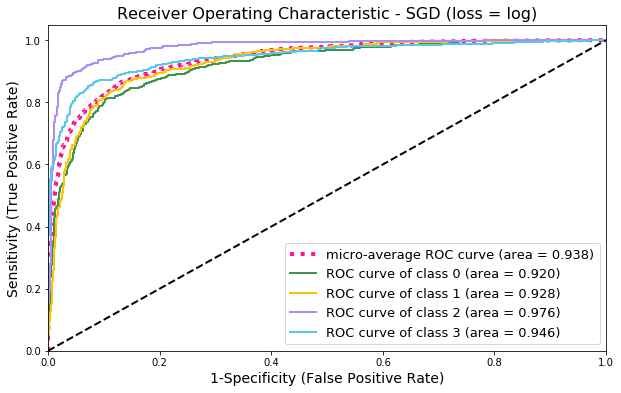

In [414]:
#Plot the ROCs of each class
plt.figure(figsize=(10,6)) 
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)


colors = ['#41924F', '#FFC300', '#a98ff3', '#59C7EA']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - SGD (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

## Confusion Matrix for SGD

In [415]:
#Train test split with stratified sampling. Using non-binarized labels
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 10)
#Fit the training data
sgd_classifier.fit(X_train, y_train)
#Predict the testing data
y_pred = sgd_classifier.predict(X_test)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred) 
cm

array([[443,  46,  39,  42],
       [ 87, 401,  43,  39],
       [  6,   1, 546,  17],
       [ 32,  13,  59, 466]], dtype=int64)

In [416]:
cm_df = pd.DataFrame(cm,
                     index = ['business','scitech','sports', 'world'], 
                     columns = ['business','scitech','sports', 'world'])

In [417]:
cm_df

,business,scitech,sports,world
business,443,46,39,42
scitech,87,401,43,39
sports,6,1,546,17
world,32,13,59,466


<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


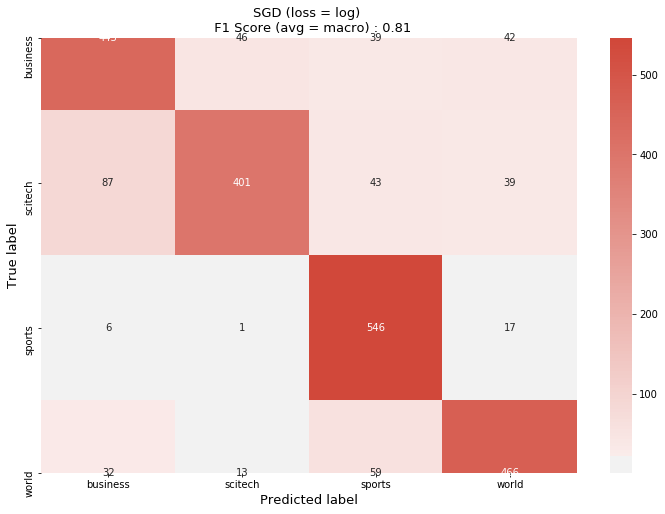

In [418]:
#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('SGD (loss = log) \n  F1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

## Conclusions
- In this data project, I performed the following:
    - Processed headline text data: tokenize, lemmatize, removed non-alphanumeric characters and stopwords, find bigrams and trigrams
    - Explored the headline text data.
    - Performed topic modelling with LDA
    - Developed a word embedding model and a t-SNE representation of the word embeddings
    - Performed modelling using textcat (CNN) in spaCY
    - Get the tf-idf representation of the headlines and performed dimension reduction.
    - Compared the performance of the following statistical learning methods:
        - SVD, Random Forest, Adaboost, KNN, Gaussian Naive Bayes
    - Optimized the models through hyperparameters tuning for SVD and Random Forest
    - Selected the "best" model based on highest f1-score (on test data)
    - Plotted the ROC of SVD and computed the confusion matrix.
    - Out of all the models, the optimized SVD model has the highest f1-score (on test dataset): about 0.81.

## Final Thoughts
- The optimized SVD model outperformed the textcat CNN model (both models uses the transformed headline text data as inputs).
- The SVD used tf-idf representations of the headlines as features.
- In the future, I will try to use CNN with word-embeddings to represent the documents. Possibly, I will use word2vec since my headline dataset is too small to train the word embedding model. This is an example of "transfer learning" since I use word-embeddings trained from a very large dataset (Google News) to compensate the limitation of my small headline dataset).